# Model exploration 
This notebook is to look for a model that can predict diabetes.

## Best model
The best model was the extra trees classifier.  With tuning the best results on the test dataset was NPV: 0.84, and PPV: 0.61.

## Data selection
The diabetes data is from a phone survey, on most questions, the survey taker can indicate Don't Know, or Refused as options.  

The first section we create 3 data sets to handle the unknown data for Don't know, Refused] we test with the values, with the values merged, and the values dropped and compare the results.

We also create a Sampled and Unsampled versions of the 3 datasets and compare the results.

Each pyCaret model and the 6 datasets are compared using the test dataset.

The results will determine the best dataset and identify the best 3 models to use.

The best dataset was the unmodified dataset, followed by the dropped dataset, then the merged dataset.

## Model selection.
We started with exploring the pyCaret models across the 6 dataset domains. The resampled data returned training results that were excellent, but predicting with a testing set provided similar results as the unsampled data.

Pretuning extra trees classifier resulted in PPV: 0.32 and NPV: 0.89.  PPV is more important in a medical prediction focusing on PPV the final best model was NPV: 0.84, and PPV: 0.61.



In [1]:
# check installed version
import pycaret
pycaret.__version__

'3.1.0'

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from pycaret.classification import *

#Samplers
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

#Utilities
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#Classifiers
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier

PyCaret’s Classification Module is a supervised machine learning module that is used for classifying elements into groups. The goal is to predict the categorical class labels which are discrete and unordered. 

In [4]:
data = pd.read_csv("diabetes_categories.csv")

In [5]:
data.head(3)

,diabetes,bmi,smoker,stroke,asthma,physical_activity,heavy_drinking,no_doctor_due_to_cost,any_healthcare_insurance,general_health_status,...,physical_health_status,difficulty_walking,gender,age,education,income,race,routine_checkup,sleep_time,heart_related
0,No,Overweight,No,No,Never,No,Yes,No,Medicare,Excellent,...,0,No,Female,80 or older,High School,"$25,000 to < $35,000",White,Never,6.0,No
1,No,Overweight,No,No,Never,Yes,Yes,No,Employer,Very good,...,1-13,No,Female,55 to 59,Graduated College,"$100,000 to < $200,000",White,Within Last Year,5.0,No
2,No,Normal,Some,No,Current,Yes,Yes,No,Refused,Excellent,...,0,No,Female,Don’t know,High School,Don’t know,White,Within Last Year,7.0,No


In [6]:
data.diabetes.value_counts()

No     267809
Yes     56130
Name: diabetes, dtype: int64

Move [Dont' know and Refused] to either the median or the closest state.

In [7]:
def SetDataFrameValue(Df, ColumnName, Old, New):
    Df.loc[Df[ColumnName] == Old, ColumnName] = New  
#    Df.drop(Df[Df[ColumnName] == Old].index, inplace=True)
    
reduced_category_data = data.copy()
SetDataFrameValue(reduced_category_data, 'stroke','Unsure','No')
SetDataFrameValue(reduced_category_data, 'stroke','Refused','No')

SetDataFrameValue(reduced_category_data, 'asthma',"Don't know",'Never')

SetDataFrameValue(reduced_category_data, 'physical_activity',"Don't know",'No')
SetDataFrameValue(reduced_category_data, 'heavy_drinking',"Don't know",'No')

SetDataFrameValue(reduced_category_data, 'no_doctor_due_to_cost','Unsure','No')
SetDataFrameValue(reduced_category_data, 'no_doctor_due_to_cost','Refused','No')


SetDataFrameValue(reduced_category_data, 'any_healthcare_insurance','Unsure','No')
SetDataFrameValue(reduced_category_data, 'any_healthcare_insurance','Refused','No')

SetDataFrameValue(reduced_category_data, 'general_health_status',"Don't know",'Very good')
SetDataFrameValue(reduced_category_data, 'general_health_status',"Refused",'Very good')

SetDataFrameValue(reduced_category_data, 'mental_health_status','Unknown','0')
SetDataFrameValue(reduced_category_data, 'physical_health_status','Unknown','0')

SetDataFrameValue(reduced_category_data, 'difficulty_walking',"Don't know",'No')
SetDataFrameValue(reduced_category_data, 'difficulty_walking','Refused','No')

SetDataFrameValue(reduced_category_data, 'age', "Don’t know", '65 to 69')

SetDataFrameValue(reduced_category_data, 'education','Not sure','High School')

SetDataFrameValue(reduced_category_data, 'income',"Don’t know",'$50,000 to < $100,000')

SetDataFrameValue(reduced_category_data, 'race',"Don't know",'White')
SetDataFrameValue(reduced_category_data, 'race','Refused','White')

SetDataFrameValue(reduced_category_data, 'routine_checkup',"Don't know",'Within Last Year')
SetDataFrameValue(reduced_category_data, 'routine_checkup','Refused','Within Last Year')

SetDataFrameValue(reduced_category_data, 'sleep_time','Refused', 7)
SetDataFrameValue(reduced_category_data, 'sleep_time',"Don't Know", 7)


Drop Don't know, Refused from a test dataset.

In [8]:
def DropDataFrameValue(Df, ColumnName, Old):
    Df.drop(Df[Df[ColumnName] == Old].index, inplace=True)
    
dropped_reduced_category_data = data.copy()
DropDataFrameValue(dropped_reduced_category_data, 'stroke','Unsure')
DropDataFrameValue(dropped_reduced_category_data, 'stroke','Refused')

DropDataFrameValue(dropped_reduced_category_data, 'asthma',"Don't know")

DropDataFrameValue(dropped_reduced_category_data, 'physical_activity',"Don't know")
DropDataFrameValue(dropped_reduced_category_data, 'heavy_drinking',"Don't know")

DropDataFrameValue(dropped_reduced_category_data, 'no_doctor_due_to_cost','Unsure')
DropDataFrameValue(dropped_reduced_category_data, 'no_doctor_due_to_cost','Refused')


DropDataFrameValue(dropped_reduced_category_data, 'any_healthcare_insurance','Unsure')
DropDataFrameValue(dropped_reduced_category_data, 'any_healthcare_insurance','Refused')

DropDataFrameValue(dropped_reduced_category_data, 'general_health_status',"Don't know")
DropDataFrameValue(dropped_reduced_category_data, 'general_health_status',"Refused")

DropDataFrameValue(dropped_reduced_category_data, 'mental_health_status','Unknown')
DropDataFrameValue(dropped_reduced_category_data, 'physical_health_status','Unknown')

DropDataFrameValue(dropped_reduced_category_data, 'difficulty_walking',"Don't know")
DropDataFrameValue(dropped_reduced_category_data, 'difficulty_walking','Refused')

DropDataFrameValue(dropped_reduced_category_data, 'age', "Don’t know")

DropDataFrameValue(dropped_reduced_category_data, 'education','Not sure')

DropDataFrameValue(dropped_reduced_category_data, 'income',"Don’t know")

DropDataFrameValue(dropped_reduced_category_data, 'race',"Don't know")
DropDataFrameValue(dropped_reduced_category_data, 'race','Refused')

DropDataFrameValue(dropped_reduced_category_data, 'routine_checkup',"Don't know")
DropDataFrameValue(dropped_reduced_category_data, 'routine_checkup','Refused')

DropDataFrameValue(dropped_reduced_category_data, 'sleep_time','Refused')
DropDataFrameValue(dropped_reduced_category_data, 'sleep_time',"Don't Know")

In [9]:
def factorize(df, ignore_column_names=None):
    factorize_keys = pd.DataFrame(columns=['ColumnName','factors'])
    pg_df = df.copy()
    if (ignore_column_names != None):
        pg_df = pg_df.drop(ignore_column_names, axis=1)
    
    for object_column_name in pg_df.select_dtypes(include=['object']).columns:
        pg_df[object_column_name],y = pd.factorize(pg_df[object_column_name])
        AddRowToDF(factorize_keys,[object_column_name,y])
            
    return pg_df, factorize_keys

In [10]:
def TrainTestSplit(data):
    train_features, test_features, train_labels, test_labels = train_test_split(data, data.diabetes, stratify=data.diabetes, random_state=42, test_size=0.20)
    test_features['diabetes'] = test_labels
    return train_features, test_features

In [11]:
def AddRowToDF(df, array):
    df.loc[len(df.index)] = array    

In [12]:
results_df = pd.DataFrame(columns=['DataSource','ModelName','TruePositive','FalsePositive','FalseNegative','TrueNegative'])

Creates datasets with the normal, reduced, and dropped data for testing

In [13]:
factorized_data, factorize_data_keys = factorize(data)
factorized_reduced_category_data, factorized_reduced_category_data_keys = factorize(reduced_category_data)
factorized_dropped_reduced_category_data, factorized_reduced_category_data_keys = factorize(dropped_reduced_category_data)

train_features, test_features = TrainTestSplit(factorized_data)
train_reduced_features, test_reduced_features = TrainTestSplit(factorized_reduced_category_data)
train_dropped_features, test_dropped_features = TrainTestSplit(factorized_dropped_reduced_category_data)

train_features_over, test_features_over = TrainTestSplit(train_features)
train_reduced_features_over, test_reduced_features_over = TrainTestSplit(train_reduced_features)
train_dropped_features_over, test_dropped_features_over = TrainTestSplit(train_dropped_features)

Tests if Oversampling helps provide best results.

In [14]:
over_sampler = SMOTE(random_state=42)
train_features_over, y_over = over_sampler.fit_resample(train_features_over, train_features_over.diabetes)
train_reduced_features_over, y_over = over_sampler.fit_resample(train_reduced_features_over, train_reduced_features_over.diabetes)
train_dropped_features_over, y_over = over_sampler.fit_resample(train_dropped_features_over, train_dropped_features_over.diabetes)


In [15]:
def CaptureResults(name, train, test ):
    s = setup(train, target = 'diabetes', session_id = 123, use_gpu = False)

    model_results = compare_models(sort='Precision', n_select=13)
    
    test_labels = test.diabetes
    test_features = test.drop('diabetes', axis=1)
    
    for model in model_results:
        print(name, model.__class__.__name__)    
        if (model.__class__.__name__ != 'KNeighborsClassifier'): #KNC doesn't work for some reason.
            prediction = model.predict(test_features)
            cm = confusion_matrix(test_labels, prediction)
            tn = cm[0][0]
            fn = cm[1][0]
            tp = cm[1][1]
            fp = cm[0][1]
            AddRowToDF(results_df, [name, model.__class__.__name__,  cm[1][1], cm[0][1], cm[1][0] , cm[0][0] ])

Check every pyCaret model with the 3 training datasets and 3 training oversampled datasets.<br />
<br />
Goal is to determine the correct dataset and if sampling the trainin data helps.

In [16]:
CaptureResults('Default', train_features, test_features)
CaptureResults('Reduced', train_reduced_features, test_reduced_features)
CaptureResults('Dropped', train_dropped_features, test_dropped_features)

CaptureResults('Over', train_features_over, test_features_over)
CaptureResults('OverReduced', train_reduced_features_over, test_reduced_features_over)
CaptureResults('OverDropped', train_dropped_features_over, test_dropped_features_over)


,Description,Value
0,Session id,123
1,Target,diabetes
2,Target type,Binary
3,Original data shape,"(259151, 21)"
4,Transformed data shape,"(259151, 21)"
5,Transformed train set shape,"(181405, 21)"
6,Transformed test set shape,"(77746, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8333,0.7915,0.1547,0.5702,0.2433,0.1829,0.2329,0.2560
gbc,Gradient Boosting Classifier,0.8326,0.7894,0.1395,0.5689,0.2240,0.1672,0.2202,3.2520
ada,Ada Boost Classifier,0.8320,0.7864,0.1624,0.5518,0.2509,0.1868,0.2318,1.1320
ridge,Ridge Classifier,0.8273,0.0000,0.0380,0.5255,0.0708,0.0486,0.1047,0.0680
lr,Logistic Regression,0.8257,0.7443,0.0781,0.4829,0.1344,0.0905,0.1388,0.6270
lda,Linear Discriminant Analysis,0.8232,0.7438,0.1270,0.4630,0.1993,0.1348,0.1710,0.1550
rf,Random Forest Classifier,0.8200,0.7529,0.1737,0.4495,0.2506,0.1705,0.1955,2.2650
et,Extra Trees Classifier,0.8169,0.7346,0.1689,0.4282,0.2422,0.1599,0.1824,2.5100
knn,K Neighbors Classifier,0.8104,0.6734,0.1702,0.3916,0.2372,0.1477,0.1646,4.4550
qda,Quadratic Discriminant Analysis,0.7668,0.7385,0.4457,0.3602,0.3984,0.2557,0.2580,0.1150


Default LGBMClassifier
Default GradientBoostingClassifier
Default AdaBoostClassifier
Default RidgeClassifier
Default LogisticRegression
Default LinearDiscriminantAnalysis
Default RandomForestClassifier
Default ExtraTreesClassifier
Default KNeighborsClassifier
Default QuadraticDiscriminantAnalysis
Default GaussianNB
Default DecisionTreeClassifier
Default SGDClassifier


,Description,Value
0,Session id,123
1,Target,diabetes
2,Target type,Binary
3,Original data shape,"(259151, 21)"
4,Transformed data shape,"(259151, 21)"
5,Transformed train set shape,"(181405, 21)"
6,Transformed test set shape,"(77746, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8334,0.7911,0.1547,0.5713,0.2434,0.1831,0.2333,0.3200
gbc,Gradient Boosting Classifier,0.8327,0.7890,0.1399,0.5709,0.2247,0.1680,0.2212,2.4470
ada,Ada Boost Classifier,0.8321,0.7859,0.1623,0.5523,0.2509,0.1869,0.2320,0.9230
ridge,Ridge Classifier,0.8275,0.0000,0.0390,0.5328,0.0727,0.0502,0.1076,0.0570
lr,Logistic Regression,0.8256,0.7458,0.0792,0.4799,0.1359,0.0913,0.1389,0.2320
lda,Linear Discriminant Analysis,0.8235,0.7448,0.1305,0.4668,0.2039,0.1387,0.1749,0.1340
rf,Random Forest Classifier,0.8190,0.7487,0.1747,0.4437,0.2507,0.1694,0.1933,2.1410
et,Extra Trees Classifier,0.8155,0.7280,0.1735,0.4213,0.2458,0.1610,0.1817,2.4860
knn,K Neighbors Classifier,0.8084,0.6720,0.1686,0.3807,0.2337,0.1425,0.1580,5.3850
qda,Quadratic Discriminant Analysis,0.7659,0.7393,0.4492,0.3596,0.3994,0.2563,0.2587,0.1080


Reduced LGBMClassifier
Reduced GradientBoostingClassifier
Reduced AdaBoostClassifier
Reduced RidgeClassifier
Reduced LogisticRegression
Reduced LinearDiscriminantAnalysis
Reduced RandomForestClassifier
Reduced ExtraTreesClassifier
Reduced KNeighborsClassifier
Reduced QuadraticDiscriminantAnalysis
Reduced GaussianNB
Reduced DecisionTreeClassifier
Reduced SGDClassifier


,Description,Value
0,Session id,123
1,Target,diabetes
2,Target type,Binary
3,Original data shape,"(197188, 21)"
4,Transformed data shape,"(197188, 21)"
5,Transformed train set shape,"(138031, 21)"
6,Transformed test set shape,"(59157, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8343,0.7903,0.1352,0.5626,0.2179,0.1625,0.2153,1.5400
lightgbm,Light Gradient Boosting Machine,0.8343,0.7918,0.1548,0.5539,0.2419,0.1808,0.2279,0.2320
ada,Ada Boost Classifier,0.8338,0.7882,0.1528,0.5503,0.2390,0.1780,0.2248,0.5980
ridge,Ridge Classifier,0.8300,0.0000,0.0446,0.5306,0.0823,0.0573,0.1153,0.0480
lr,Logistic Regression,0.8285,0.7517,0.0871,0.4881,0.1478,0.1014,0.1495,0.1520
lda,Linear Discriminant Analysis,0.8266,0.7501,0.1383,0.4742,0.2141,0.1484,0.1845,0.1060
rf,Random Forest Classifier,0.8228,0.7466,0.1762,0.4526,0.2536,0.1746,0.1998,1.3750
et,Extra Trees Classifier,0.8183,0.7264,0.1764,0.4241,0.2491,0.1653,0.1861,1.5310
knn,K Neighbors Classifier,0.8123,0.6746,0.1736,0.3892,0.2401,0.1505,0.1666,3.0140
qda,Quadratic Discriminant Analysis,0.7697,0.7434,0.4503,0.3607,0.4005,0.2601,0.2626,0.0810


Dropped GradientBoostingClassifier
Dropped LGBMClassifier
Dropped AdaBoostClassifier
Dropped RidgeClassifier
Dropped LogisticRegression
Dropped LinearDiscriminantAnalysis
Dropped RandomForestClassifier
Dropped ExtraTreesClassifier
Dropped KNeighborsClassifier
Dropped QuadraticDiscriminantAnalysis
Dropped GaussianNB
Dropped DecisionTreeClassifier
Dropped SGDClassifier


,Description,Value
0,Session id,123
1,Target,diabetes
2,Target type,Binary
3,Original data shape,"(342794, 21)"
4,Transformed data shape,"(342794, 21)"
5,Transformed train set shape,"(239955, 21)"
6,Transformed test set shape,"(102839, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8184,0.9005,0.8393,0.8057,0.8221,0.6368,0.6374,3.8140
rf,Random Forest Classifier,0.8176,0.9023,0.8566,0.7945,0.8244,0.6351,0.6371,3.1210
dt,Decision Tree Classifier,0.7674,0.7766,0.8070,0.7478,0.7763,0.5348,0.5365,0.2230
knn,K Neighbors Classifier,0.7840,0.8668,0.9119,0.7262,0.8085,0.5680,0.5876,8.9750
lightgbm,Light Gradient Boosting Machine,0.7436,0.8235,0.7833,0.7257,0.7534,0.4872,0.4888,0.3600
ada,Ada Boost Classifier,0.7280,0.8036,0.7593,0.7145,0.7362,0.4559,0.4568,1.3480
gbc,Gradient Boosting Classifier,0.7312,0.8086,0.7715,0.7140,0.7416,0.4624,0.4640,3.4800
svm,SVM - Linear Kernel,0.6765,0.0000,0.6622,0.6851,0.6681,0.3531,0.3577,0.3690
lr,Logistic Regression,0.6867,0.7511,0.7010,0.6816,0.6911,0.3735,0.3736,0.2490
ridge,Ridge Classifier,0.6860,0.0000,0.7010,0.6806,0.6906,0.3720,0.3722,0.0690


Over ExtraTreesClassifier
Over RandomForestClassifier
Over DecisionTreeClassifier
Over KNeighborsClassifier
Over LGBMClassifier
Over AdaBoostClassifier
Over GradientBoostingClassifier
Over SGDClassifier
Over LogisticRegression
Over RidgeClassifier
Over LinearDiscriminantAnalysis
Over GaussianNB
Over QuadraticDiscriminantAnalysis


,Description,Value
0,Session id,123
1,Target,diabetes
2,Target type,Binary
3,Original data shape,"(342794, 21)"
4,Transformed data shape,"(342794, 21)"
5,Transformed train set shape,"(239955, 21)"
6,Transformed test set shape,"(102839, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8160,0.8974,0.8365,0.8036,0.8197,0.6320,0.6325,3.6760
rf,Random Forest Classifier,0.8167,0.9005,0.8575,0.7928,0.8239,0.6334,0.6355,3.1380
dt,Decision Tree Classifier,0.7699,0.7808,0.8092,0.7502,0.7786,0.5397,0.5414,0.2180
lightgbm,Light Gradient Boosting Machine,0.7468,0.8257,0.7941,0.7255,0.7582,0.4936,0.4959,0.4120
knn,K Neighbors Classifier,0.7743,0.8581,0.9060,0.7171,0.8006,0.5486,0.5687,9.1790
gbc,Gradient Boosting Classifier,0.7359,0.8125,0.7870,0.7140,0.7487,0.4718,0.4743,3.5090
ada,Ada Boost Classifier,0.7313,0.8071,0.7734,0.7134,0.7422,0.4627,0.4643,1.3450
svm,SVM - Linear Kernel,0.6787,0.0000,0.6346,0.6994,0.6607,0.3573,0.3627,0.3270
lr,Logistic Regression,0.6943,0.7595,0.7230,0.6838,0.7028,0.3886,0.3893,0.3080
ridge,Ridge Classifier,0.6923,0.0000,0.7214,0.6817,0.7010,0.3845,0.3852,0.0700


OverReduced ExtraTreesClassifier
OverReduced RandomForestClassifier
OverReduced DecisionTreeClassifier
OverReduced LGBMClassifier
OverReduced KNeighborsClassifier
OverReduced GradientBoostingClassifier
OverReduced AdaBoostClassifier
OverReduced SGDClassifier
OverReduced LogisticRegression
OverReduced RidgeClassifier
OverReduced LinearDiscriminantAnalysis
OverReduced GaussianNB
OverReduced QuadraticDiscriminantAnalysis


,Description,Value
0,Session id,123
1,Target,diabetes
2,Target type,Binary
3,Original data shape,"(261598, 21)"
4,Transformed data shape,"(261598, 21)"
5,Transformed train set shape,"(183118, 21)"
6,Transformed test set shape,"(78480, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8248,0.9042,0.8483,0.8102,0.8288,0.6496,0.6503,2.5150
rf,Random Forest Classifier,0.8228,0.9064,0.8662,0.7971,0.8302,0.6456,0.6481,2.2180
dt,Decision Tree Classifier,0.7763,0.7856,0.8187,0.7547,0.7854,0.5526,0.5546,0.1530
lightgbm,Light Gradient Boosting Machine,0.7523,0.8316,0.7981,0.7312,0.7632,0.5046,0.5068,0.3210
ada,Ada Boost Classifier,0.7385,0.8144,0.7777,0.7212,0.7483,0.4770,0.4785,0.9170
knn,K Neighbors Classifier,0.7805,0.8644,0.9152,0.7210,0.8066,0.5610,0.5826,3.5460
gbc,Gradient Boosting Classifier,0.7418,0.8187,0.7926,0.7195,0.7543,0.4835,0.4861,2.3940
lr,Logistic Regression,0.7021,0.7683,0.7311,0.6911,0.7105,0.4043,0.4050,0.2410
svm,SVM - Linear Kernel,0.6931,0.0000,0.7111,0.6901,0.6958,0.3862,0.3916,0.2630
ridge,Ridge Classifier,0.7004,0.0000,0.7307,0.6889,0.7092,0.4007,0.4015,0.0580


OverDropped ExtraTreesClassifier
OverDropped RandomForestClassifier
OverDropped DecisionTreeClassifier
OverDropped LGBMClassifier
OverDropped AdaBoostClassifier
OverDropped KNeighborsClassifier
OverDropped GradientBoostingClassifier
OverDropped LogisticRegression
OverDropped SGDClassifier
OverDropped RidgeClassifier
OverDropped LinearDiscriminantAnalysis
OverDropped GaussianNB
OverDropped QuadraticDiscriminantAnalysis


Display the Negative and Positive Predicted value

In [17]:
results_df['NegativePredictedValue'] = results_df.TrueNegative / (results_df.TrueNegative+results_df.FalseNegative)
results_df['PositivePredictedValue'] = results_df.TruePositive / (results_df.TruePositive+results_df.FalsePositive)
results_df['SumPredictedValue'] = results_df['NegativePredictedValue'] + results_df['PositivePredictedValue'] 

In [18]:
results_df.sort_values('PositivePredictedValue', ascending=False).head(10)

,DataSource,ModelName,TruePositive,FalsePositive,FalseNegative,TrueNegative,NegativePredictedValue,PositivePredictedValue,SumPredictedValue
24,Dropped,GradientBoostingClassifier,1102,855,7320,40020,0.845374,0.563107,1.408481
26,Dropped,AdaBoostClassifier,1298,1013,7124,39862,0.848380,0.561662,1.410042
12,Reduced,LGBMClassifier,1747,1366,9479,52196,0.846307,0.561195,1.407502
25,Dropped,LGBMClassifier,1303,1021,7119,39854,0.848445,0.560671,1.409116
0,Default,LGBMClassifier,1732,1362,9494,52200,0.846111,0.559793,1.405905
13,Reduced,GradientBoostingClassifier,1547,1251,9679,52311,0.843862,0.552895,1.396757
1,Default,GradientBoostingClassifier,1549,1257,9677,52305,0.843874,0.552031,1.395905
2,Default,AdaBoostClassifier,1686,1436,9540,52126,0.845296,0.540038,1.385334
15,Reduced,RidgeClassifier,440,379,10786,53183,0.831387,0.537241,1.368628
14,Reduced,AdaBoostClassifier,1822,1585,9404,51977,0.846793,0.534781,1.381574


The key factor in determining Diabetes is True Negative, is it's better to predict the best TrueNegative if the patient has diabetes than overall accuracy.

There were 2 series of 3 Datasets.
The 2 series included default and oversampled selections, of 3 datasets, Default, Reduced and Dropped.

Default, Reduced, Dropped 
    The Default took the data as provided without any manipulation.
    The Reduced merged outliers such as Refusal to answer a question into either the mean or the negative response.  For example, Don't know and Refused with the question of asthma, was moved into the No category.  The merged answers were the smallest of the categories and were included in 16 data points.
    The Dropped is the same as reduced above, but instead of merging the data the entire record was removed.

The first series outperformed the OverSampling series when using the Reduced and Default Data selections.
GaussianNB and QuadraticDiscriminantAnalysis also performed very well.


In [19]:
train_features_over.head(2)

,diabetes,bmi,smoker,stroke,asthma,physical_activity,heavy_drinking,no_doctor_due_to_cost,any_healthcare_insurance,general_health_status,...,physical_health_status,difficulty_walking,gender,age,education,income,race,routine_checkup,sleep_time,heart_related
0,0,0,0,0,0,1,0,0,10,4,...,0,0,1,9,1,2,1,3,0,0
1,0,1,0,0,0,1,2,0,6,1,...,0,0,0,13,0,7,0,1,2,0


In [20]:
#train_dropped_features, test_dropped_features

s = setup(train_dropped_features_over, target = 'diabetes', session_id = 123, use_gpu = False)
gbc = create_model('gbc')
lightgbm = create_model('lightgbm')
ada = create_model('ada')

# plot_model(gbc,plot='confusion_matrix')
# plot_model(lightgbm,plot='confusion_matrix')
# plot_model(ada,plot='confusion_matrix')


,Description,Value
0,Session id,123
1,Target,diabetes
2,Target type,Binary
3,Original data shape,"(261598, 21)"
4,Transformed data shape,"(261598, 21)"
5,Transformed train set shape,"(183118, 21)"
6,Transformed test set shape,"(78480, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7400,0.8178,0.7993,0.7146,0.7545,0.4800,0.4834
1,0.7371,0.8142,0.7877,0.7153,0.7497,0.4741,0.4766
2,0.7484,0.8232,0.7963,0.7267,0.7599,0.4968,0.4991
3,0.7385,0.8179,0.7891,0.7166,0.7511,0.4771,0.4795
4,0.7393,0.8173,0.7907,0.7170,0.7521,0.4786,0.4811
5,0.7357,0.8153,0.7786,0.7171,0.7466,0.4715,0.4732
6,0.7367,0.8133,0.7914,0.7134,0.7504,0.4735,0.4763
7,0.7456,0.8214,0.7935,0.7241,0.7572,0.4912,0.4934
8,0.7473,0.8253,0.8014,0.7232,0.7603,0.4946,0.4975


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7498,0.8308,0.7985,0.7277,0.7614,0.4997,0.5021
1,0.7507,0.8269,0.7957,0.7300,0.7614,0.5013,0.5034
2,0.7603,0.8362,0.8068,0.7381,0.7709,0.5205,0.5228
3,0.7473,0.8305,0.7918,0.7270,0.7581,0.4945,0.4965
4,0.7495,0.8295,0.7981,0.7274,0.7611,0.4989,0.5013
5,0.7466,0.8281,0.7863,0.7285,0.7563,0.4932,0.4948
6,0.7475,0.8269,0.7975,0.7251,0.7596,0.4951,0.4976
7,0.7564,0.8347,0.7984,0.7366,0.7662,0.5129,0.5147
8,0.7581,0.8367,0.8042,0.7363,0.7687,0.5161,0.5183


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7379,0.8142,0.7771,0.7206,0.7478,0.4758,0.4772
1,0.7355,0.8108,0.7727,0.7192,0.7450,0.4709,0.4723
2,0.7455,0.8203,0.7855,0.7273,0.7553,0.4909,0.4925
3,0.7351,0.8127,0.7737,0.7182,0.7449,0.4702,0.4716
4,0.7356,0.8113,0.7758,0.7181,0.7458,0.4712,0.4727
5,0.7333,0.8112,0.7701,0.7174,0.7428,0.4667,0.4680
6,0.7344,0.8086,0.7756,0.7166,0.7449,0.4689,0.4705
7,0.7404,0.8172,0.7774,0.7239,0.7497,0.4809,0.4822
8,0.7438,0.8204,0.7821,0.7265,0.7533,0.4876,0.4891


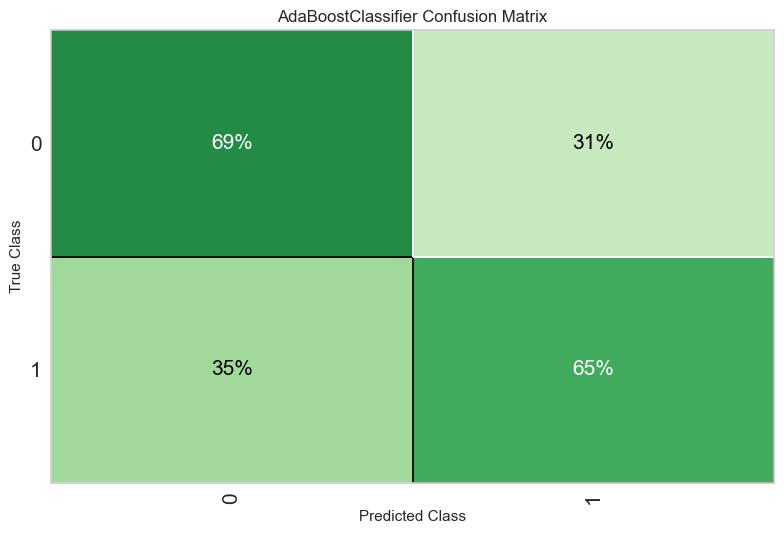

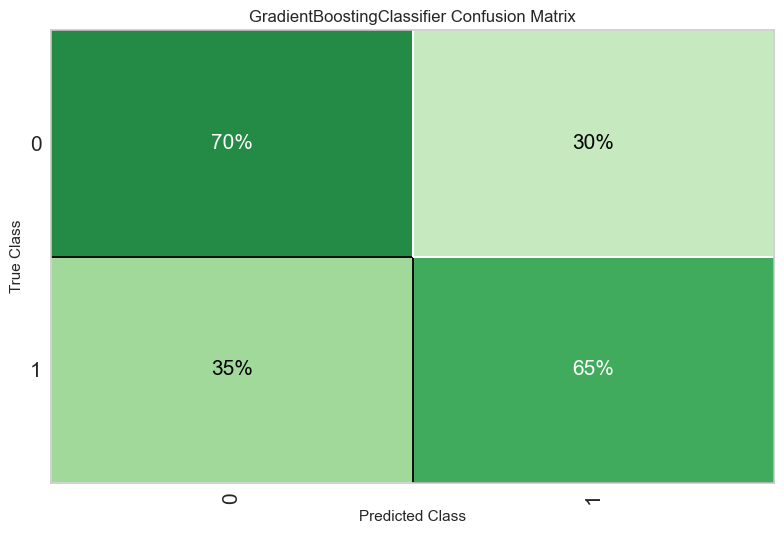

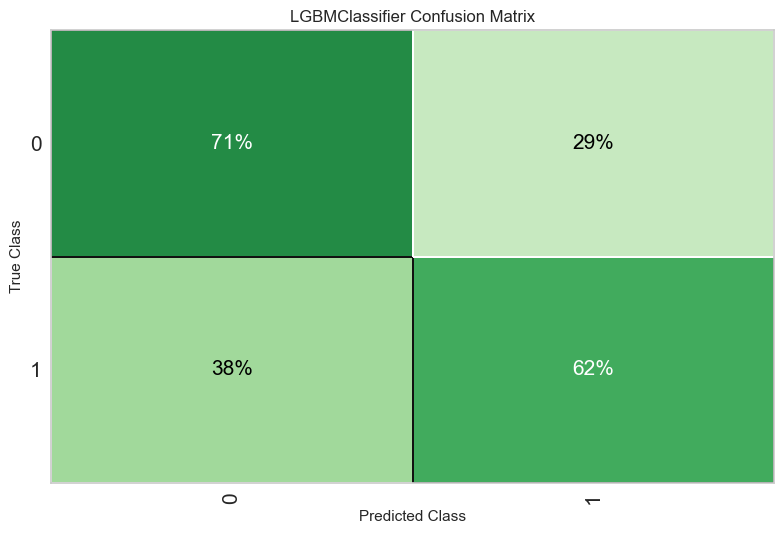

In [81]:
plot_model(ada, plot='confusion_matrix', plot_kwargs = {'percent':True})
plot_model(gbc, plot='confusion_matrix', plot_kwargs = {'percent':True})
plot_model(lightgbm, plot='confusion_matrix', plot_kwargs = {'percent':True})

It would be better to predict on the training set to determine the best model on the best dataset and sampling set to determine<br>
<br>
This resulted in the Extra tree's being the best model to use.

In [25]:
def CompareModels(model_name):
    model = create_model(model_name, verbose=False)
    DisplayModel(model, model_name)

In [29]:
def DisplayModel(model, name=''):
    test_labels = test_dropped_features.diabetes
    test_features = test_dropped_features.drop('diabetes', axis=1)
    prediction = model.predict(test_features)
    #plot_model(tuned_dt, plot='confusion_matrix')

    cm = confusion_matrix(test_labels, prediction)
    tn = cm[0][0]
    fn = cm[1][0]
    tp = cm[1][1]
    fp = cm[0][1]

    print(f'{name}')
    print(f'{tp} {fp}')
    print(f'{fn} {tn}')
    print(f'PPV: {tp / (tp+fp)}')
    print(f'NPV: {tn / (tn+fn)}\n')

In [30]:
CompareModels('et')
CompareModels('rf')
CompareModels('dt')
CompareModels('lightgbm')
CompareModels('ada')
#CompareModels('knn')
CompareModels('gbc')
CompareModels('lr')
CompareModels('svm')
CompareModels('ridge')
CompareModels('lda')
CompareModels('nb')
CompareModels('qda')
CompareModels('dummy')

et
3757 7973
4665 32902
PPV: 0.32028985507246377
NPV: 0.8758218649346501

rf
4198 8921
4224 31954
PPV: 0.31999390197423583
NPV: 0.8832439604179335

dt
3863 10638
4559 30237
PPV: 0.2663954210054479
NPV: 0.8689791930106909

lightgbm
5642 12186
2780 28689
PPV: 0.3164684765537357
NPV: 0.9116590930757253

ada
5657 12438
2765 28437
PPV: 0.3126277977341807
NPV: 0.9113838856483559

gbc
5936 12759
2486 28116
PPV: 0.31751805295533564
NPV: 0.918763479511143

lr
5371 13493
3051 27382
PPV: 0.2847222222222222
NPV: 0.8997469851805606

svm
5982 15739
2440 25136
PPV: 0.27540168500529444
NPV: 0.9115172613867131

ridge
5414 13594
3008 27281
PPV: 0.28482744107744107
NPV: 0.9006900194790188

lda
5414 13594
3008 27281
PPV: 0.28482744107744107
NPV: 0.9006900194790188

nb
6808 23043
1614 17832
PPV: 0.22806606143847777
NPV: 0.9170009256402345

qda
6809 23818
1613 17057
PPV: 0.222320175008979
NPV: 0.9136047134440278

dummy
0 0
8422 40875
PPV: nan
NPV: 0.8291579609306854



Extra tree's had the highest PPV value.

In [32]:
et = create_model('et')
DisplayModel(et,'et')

tuned_et = tune_model(et,  choose_better = True)
DisplayModel(tuned_et,'et tuned')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8238,0.9031,0.8482,0.8088,0.8280,0.6477,0.6484
1,0.8216,0.9003,0.8452,0.8071,0.8257,0.6432,0.6439
2,0.8288,0.9104,0.8495,0.8157,0.8323,0.6576,0.6582
3,0.8261,0.9050,0.8511,0.8105,0.8303,0.6521,0.6530
4,0.8242,0.9033,0.8460,0.8107,0.8280,0.6484,0.6490
5,0.8259,0.9044,0.8480,0.8120,0.8296,0.6517,0.6523
6,0.8214,0.9004,0.8485,0.8049,0.8261,0.6429,0.6438
7,0.8293,0.9068,0.8519,0.8151,0.8331,0.6587,0.6594
8,0.8198,0.9013,0.8413,0.8066,0.8236,0.6396,0.6402


et
3757 7973
4665 32902
PPV: 0.32028985507246377
NPV: 0.8758218649346501



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7222,0.7904,0.7870,0.6967,0.7391,0.4444,0.4482
1,0.7153,0.7879,0.7726,0.6931,0.7307,0.4305,0.4334
2,0.7258,0.7977,0.7819,0.7030,0.7404,0.4516,0.4545
3,0.7193,0.7876,0.7792,0.6958,0.7351,0.4385,0.4417
4,0.7271,0.7929,0.7792,0.7056,0.7406,0.4541,0.4566
5,0.7136,0.7875,0.7685,0.6925,0.7285,0.4272,0.4297
6,0.7136,0.7861,0.7627,0.6945,0.7270,0.4272,0.4292
7,0.7243,0.7952,0.7760,0.7033,0.7378,0.4486,0.4510
8,0.7248,0.7970,0.7866,0.7000,0.7408,0.4495,0.4530


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
et tuned
3757 7973
4665 32902
PPV: 0.32028985507246377
NPV: 0.8758218649346501



In [ ]:
test_labels = test_features.diabetes
test_features = test_features.drop('diabetes', axis=1)

In [ ]:
bagging = ensemble_model(gbc,choose_better=True)
prediction = bagging.predict(test_features)
print(bagging)
#plot_model(tuned_dt, plot='confusion_matrix')

cm = confusion_matrix(test_labels, prediction)
tn = cm[0][0]
fn = cm[1][0]
tp = cm[1][1]
fp = cm[0][1]

print(f'Positive: {tp / (tp+fp)}')
print(f'Negative: {tn / (tn+fn)}')

In [ ]:
boosted = ensemble_model(gbc,choose_better=True, method='Boosting')
prediction = boosted.predict(test_features.drop('diabetes',axis=1))
print(boosted)
#plot_model(tuned_dt, plot='confusion_matrix')

cm = confusion_matrix(test_labels, prediction)
tn = cm[0][0]
fn = cm[1][0]
tp = cm[1][1]
fp = cm[0][1]

print(f'Positive: {tp / (tp+fp)}')
print(f'Negative: {tn / (tn+fn)}')


## Pull in the best data with the best sampler

In [49]:
# data
# reduced_category_data
# dropped_reduced_category_data

#def TrainOnData(data):
train_features, test_features, train_labels, test_labels = train_test_split(factorized_data, factorized_data.diabetes, stratify=factorized_data.diabetes, random_state=42, test_size=0.20)

over_sampler = RandomOverSampler(random_state=42)
X_over, y_over = over_sampler.fit_resample(train_features, train_labels)
sampled_data = X_over
# sampled_data['diabetes'] = y_over
# sampled_data.diabetes.value_counts()

s = setup(X_over, target = 'diabetes', session_id = 123, use_gpu = False)

best_default = compare_models(sort='Recall', n_select=13)

test_labels = test_features.diabetes
test_features = test_features.drop('diabetes', axis=1)


,Description,Value
0,Session id,123
1,Target,diabetes
2,Target type,Binary
3,Original data shape,"(428494, 21)"
4,Transformed data shape,"(428494, 21)"
5,Transformed train set shape,"(299945, 21)"
6,Transformed test set shape,"(128549, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9002,0.9739,0.9614,0.8566,0.9060,0.8004,0.8065,4.3960
dt,Decision Tree Classifier,0.8722,0.8853,0.9553,0.8191,0.8820,0.7443,0.7548,0.3120
et,Extra Trees Classifier,0.9227,0.9783,0.9516,0.8996,0.9249,0.8454,0.8468,5.0820
knn,K Neighbors Classifier,0.7716,0.8455,0.8644,0.7290,0.7910,0.5431,0.5527,10.4690
lightgbm,Light Gradient Boosting Machine,0.7249,0.7980,0.7614,0.7097,0.7346,0.4499,0.4511,0.4780
gbc,Gradient Boosting Classifier,0.7194,0.7911,0.7527,0.7058,0.7285,0.4389,0.4399,5.1970
ada,Ada Boost Classifier,0.7171,0.7871,0.7407,0.7073,0.7236,0.4342,0.4347,1.9850
dummy,Dummy Classifier,0.5000,0.5000,0.7000,0.3500,0.4667,0.0000,0.0000,0.0600
lr,Logistic Regression,0.6838,0.7452,0.6862,0.6830,0.6846,0.3677,0.3677,0.6270
ridge,Ridge Classifier,0.6835,0.0000,0.6862,0.6826,0.6844,0.3671,0.3671,0.0840


In [46]:
def AddRowToDF(df, array):
    df.loc[len(df.index)] = array    

In [47]:
results_df = pd.DataFrame(columns=['DataSource','ModelName','TruePositive','FalsePositive','FalseNegative','TrueNegative'])

In [50]:
for model in best_default:
    print(model.__class__.__name__)    
    if (model.__class__.__name__ != 'KNeighborsClassifier'): #KNC doesn't work for some reason.
        prediction = model.predict(test_features)
        result = confusion_matrix(test_labels, prediction)
        AddRowToDF(results_df, ['Test',model.__class__.__name__,result[0][0],result[0][1], result[1][0], result[1][1] ])
    

RandomForestClassifier
DecisionTreeClassifier
ExtraTreesClassifier
KNeighborsClassifier
LGBMClassifier
GradientBoostingClassifier
AdaBoostClassifier
DummyClassifier
LogisticRegression
RidgeClassifier
LinearDiscriminantAnalysis
SGDClassifier
QuadraticDiscriminantAnalysis


In [55]:
results_df['NegativePredictedValue'] = results_df.TrueNegative / (results_df.TrueNegative+results_df.FalseNegative)
results_df['PositivePredictedValue'] = results_df.TruePositive / (results_df.TruePositive+results_df.FalsePositive)
results_df['SumPredictedValue'] = results_df['NegativePredictedValue'] + results_df['PositivePredictedValue'] 

In [ ]:
results_df.sort_values('SumPredictedValue', ascending=False).head(100)

,DataSource,ModelName,TruePositive,FalsePositive,FalseNegative,TrueNegative,NegativePredictedValue,PositivePredictedValue,SumPredictedValue
4,Test,GradientBoostingClassifier,36980,16582,2821,8405,0.748708,0.690415,1.439123
3,Test,LGBMClassifier,36934,16628,2829,8397,0.747996,0.689556,1.437552
5,Test,AdaBoostClassifier,37206,16356,2920,8306,0.739890,0.694634,1.434524
7,Test,LogisticRegression,36388,17174,3457,7769,0.692054,0.679362,1.371416
8,Test,RidgeClassifier,36359,17203,3471,7755,0.690807,0.678821,1.369628
9,Test,LinearDiscriminantAnalysis,36359,17203,3471,7755,0.690807,0.678821,1.369628
10,Test,SGDClassifier,36158,17404,3527,7699,0.685819,0.675068,1.360887
11,Test,QuadraticDiscriminantAnalysis,38360,15202,4069,7157,0.637538,0.716179,1.353717
0,Test,RandomForestClassifier,45609,7953,6432,4794,0.427044,0.851518,1.278562
2,Test,ExtraTreesClassifier,48577,4985,8056,3170,0.282380,0.906930,1.189310


In [ ]:
# TrainOnData(reduced_category_dataata)
# TrainOnData(dropped_reduced_category_data)

Many features had Unsure/Refused categories try setting those to the non-positive condition and retest.

In [63]:
def PositivePredictedValue(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tp = cm[1, 1]
    return tp/(tp+fp)

Even though other models delivered higher out of the box performance, extra trees was better when tuned.<br>
<br>
The parameters below resulted in the best prediction with the training data

In [52]:
train_labels = train_dropped_features.diabetes
train_features = train_dropped_features.drop('diabetes', axis=1)

params = [{ 'criterion': ['gini'],
            'n_estimators': [100], #700
            'min_samples_split': [67],
            'min_samples_leaf':[6]
         }]

etc  = GridSearchCV(ExtraTreesClassifier(),
                      param_grid=params,
                      scoring=make_scorer(PositivePredictedValue, greater_is_better=True),
                      cv=5,
                      verbose=3)
etc.fit(train_features, train_labels)
print(etc.best_params_)

DisplayModel(etc.best_estimator_, 'ExtraTreesClassifier')

best_model = etc.best_estimator_


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=gini, min_samples_leaf=6, min_samples_split=67, n_estimators=100;, score=0.582 total time=  16.4s
[CV 2/5] END criterion=gini, min_samples_leaf=6, min_samples_split=67, n_estimators=100;, score=0.622 total time=  17.2s
[CV 3/5] END criterion=gini, min_samples_leaf=6, min_samples_split=67, n_estimators=100;, score=0.602 total time=  17.3s
[CV 4/5] END criterion=gini, min_samples_leaf=6, min_samples_split=67, n_estimators=100;, score=0.601 total time=  17.4s
[CV 5/5] END criterion=gini, min_samples_leaf=6, min_samples_split=67, n_estimators=100;, score=0.591 total time=  17.0s
{'criterion': 'gini', 'min_samples_leaf': 6, 'min_samples_split': 67, 'n_estimators': 100}
ExtraTreesClassifier
493 318
7929 40557
PPV: 0.6078914919852034
NPV: 0.8364682588788517



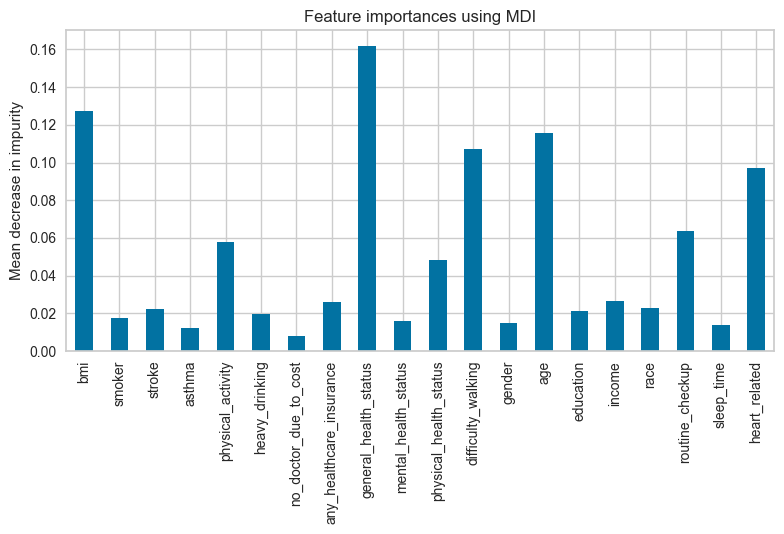

In [80]:
etc_importances = pd.Series(etc.best_estimator_.feature_importances_, index=train_features.columns)
fig, ax = plt.subplots()
etc_importances.plot.bar( ax=ax)
ax.set_title("Feature importances Extra Trees Classifier")
fig.tight_layout()

In [64]:
test_labels = test_dropped_features.diabetes
test_features = test_dropped_features.drop('diabetes', axis=1)
prediction = best_model.predict(test_features)
test_features['predict'] = prediction
test_features['diabetes'] = test_dropped_features.diabetes



In [67]:
test_features['accurate'] = (test_features.predict == test_features.diabetes).astype(int)

In [69]:
def SetDataFrameValue(ColumnName, Old, New, Df):
    Df.loc[Df[ColumnName] == Old, ColumnName] = New  

In [70]:
for index, row in factorized_reduced_category_data_keys.iterrows():
    print(row['ColumnName'], row['factors'])
    i = 0
    for factor in row['factors']:
        SetDataFrameValue(row['ColumnName'],i,factor, test_features)
        i=i+1
        
    
    #SetDataFrameValue(row.ColumName,)
    

diabetes Index(['No', 'Yes'], dtype='object')
bmi Index(['Overweight', 'Normal', 'Obese', 'Under'], dtype='object')
smoker Index(['No', 'Some', 'Current', 'Former'], dtype='object')
stroke Index(['No', 'Yes'], dtype='object')
asthma Index(['Never', 'Current', 'Former'], dtype='object')
physical_activity Index(['No', 'Yes'], dtype='object')
heavy_drinking Index(['Yes', 'No'], dtype='object')
no_doctor_due_to_cost Index(['No', 'Yes'], dtype='object')
any_healthcare_insurance Index(['Medicare', 'Employer', 'Military', 'Private', 'Medigap', 'Other',
       'Medicaid', 'No', 'State', 'Indian', 'CHIP'],
      dtype='object')
general_health_status Index(['Excellent', 'Very good', 'Fair', 'Good', 'Poor', 'Don’t know'], dtype='object')
mental_health_status Index(['0', '1-13', '14+'], dtype='object')
physical_health_status Index(['0', '1-13', '14+'], dtype='object')
difficulty_walking Index(['No', 'Yes', 'Don’t know'], dtype='object')
gender Index(['Female', 'Male'], dtype='object')
age Index(['

In [71]:
def BasicAnalysisGraph(ColumnName, Title, ShowCount=True, Data=test_features, GroupBy='accurate'):
    bins = len(Data[ColumnName].unique())
    if (bins > 20):
        bins = 20
        
    if(ShowCount):
        display(pd.DataFrame(Data.groupby([GroupBy,ColumnName])[GroupBy].describe()['count']))
        
    ax = sns.histplot(Data, x=ColumnName, hue=GroupBy, element='poly', bins=bins).set(title=f'{GroupBy.title()} by {Title}')

Compile a list of data with the accuracy of the Model and the Model with diabetes only.

In [72]:
def GetAccuracyDF(test_features):
    accuracy_df = pd.DataFrame(columns=['feature','value','Accuracy'])

    for column_name in test_features.columns:
        df = pd.DataFrame(test_features.groupby([column_name, 'accurate'])['accurate'].count())
        for index, row in df.iterrows():
            data_value = row.name[0]
            row_value = row[0]
            if (row.name[1]==1):
                AddRowToDF(accuracy_df, [column_name, data_value, 100*(row_value / (last_row_value+row_value))])
            last_data_value = data_value
            last_row_value = row_value
            
    return accuracy_df

accuracy_df = GetAccuracyDF(test_features)
diabetes_accuracy_df = GetAccuracyDF(test_features[test_features.diabetes=='Yes'])

In [ ]:
# accuracy_df = pd.DataFrame(columns=['feature','value','Accuracy'])

# for column_name in test_features.columns:
#     df = pd.DataFrame(test_features.groupby([column_name, 'accurate'])['accurate'].count())
#     for index, row in df.iterrows():
#         data_value = row.name[0]
#         row_value = row[0]
#         if (row.name[1]==1):
#             AddRowToDF(accuracy_df, [column_name, data_value, 100*(row_value / (last_row_value+row_value))])
#         last_data_value = data_value
#         last_row_value = row_value
        
# accuracy_df


# Display the overall model accuracy to the diabetes accuracy

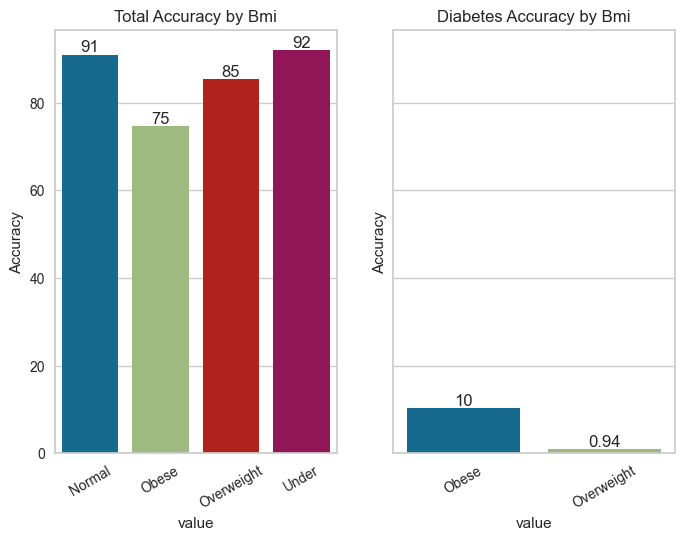

<Figure size 800x550 with 0 Axes>

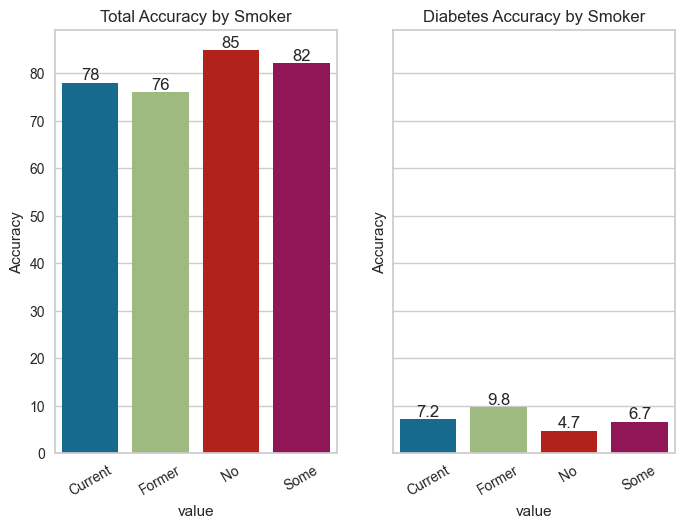

<Figure size 800x550 with 0 Axes>

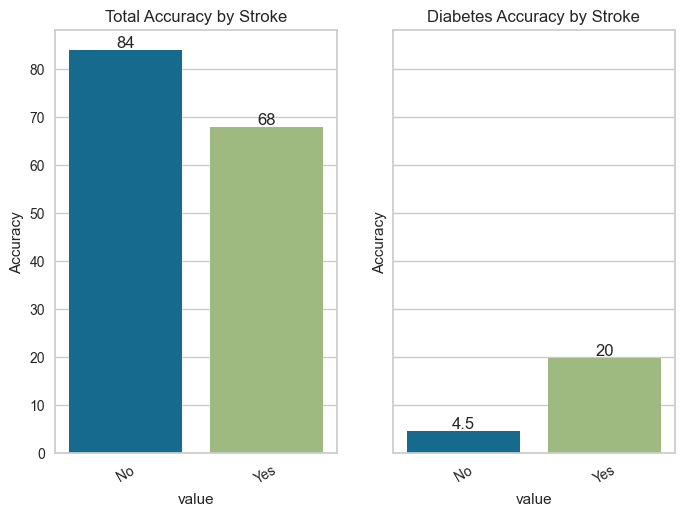

<Figure size 800x550 with 0 Axes>

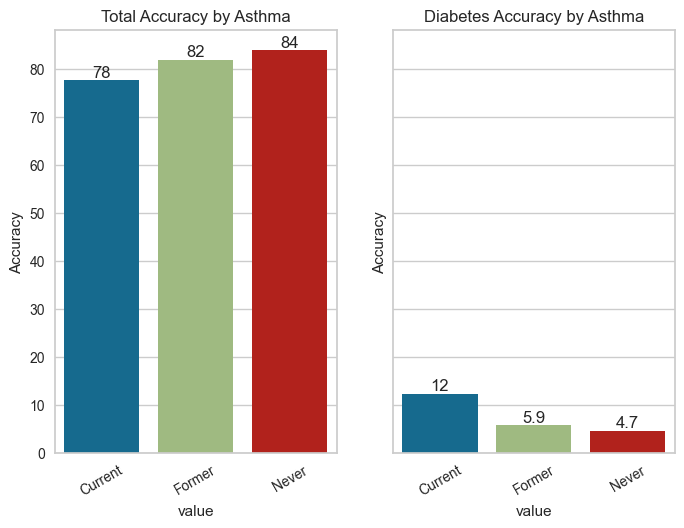

<Figure size 800x550 with 0 Axes>

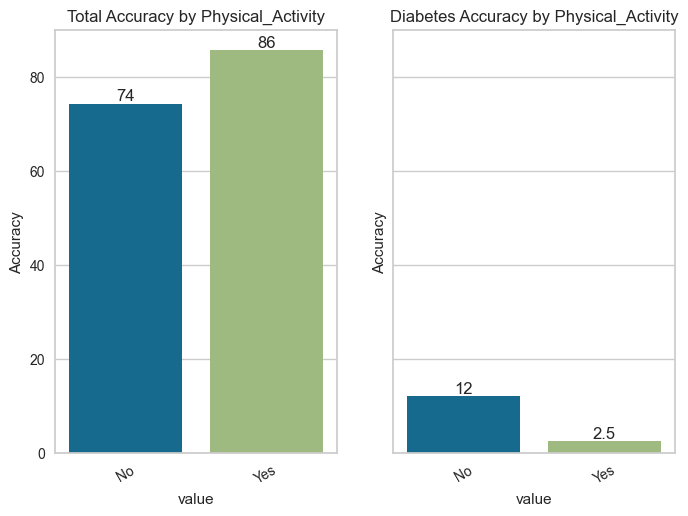

<Figure size 800x550 with 0 Axes>

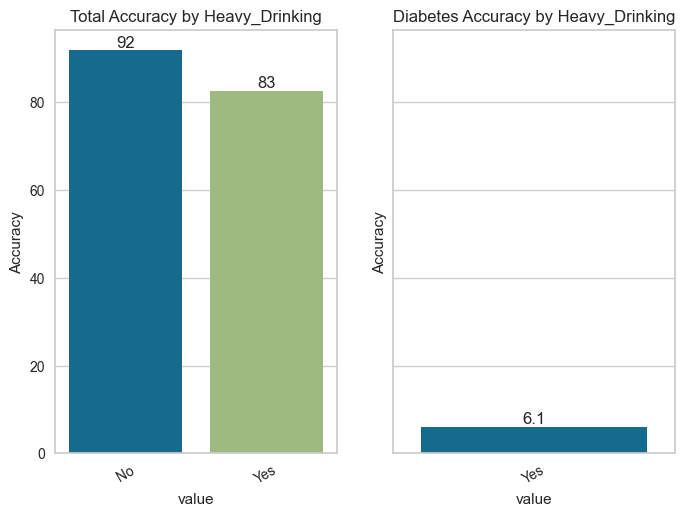

<Figure size 800x550 with 0 Axes>

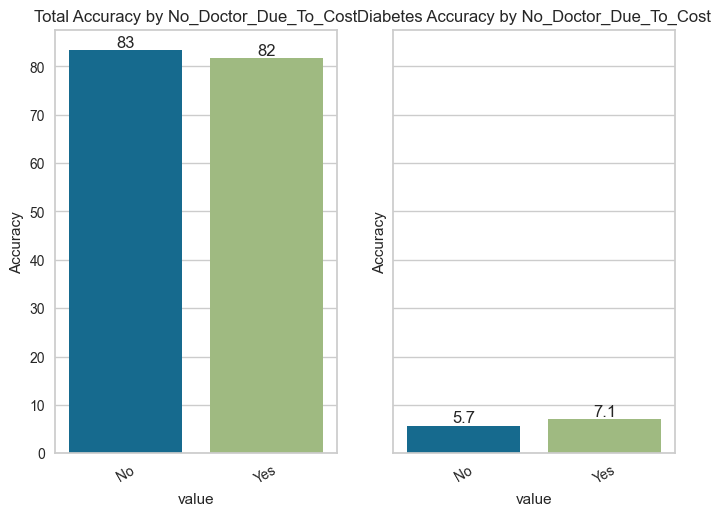

<Figure size 800x550 with 0 Axes>

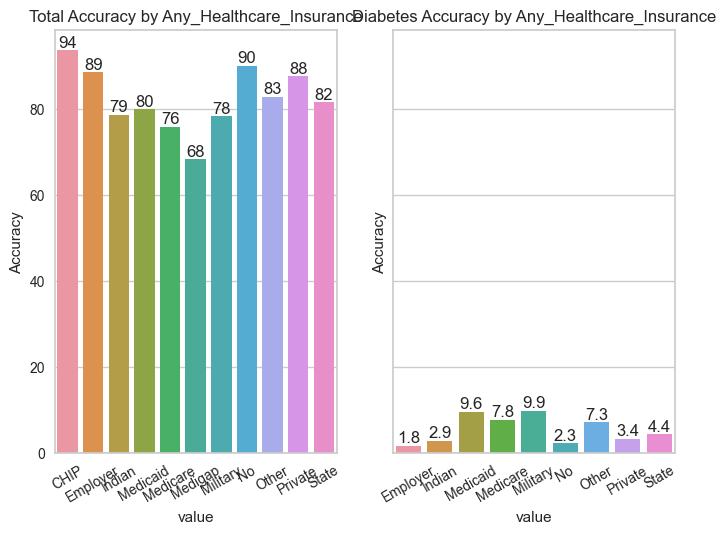

<Figure size 800x550 with 0 Axes>

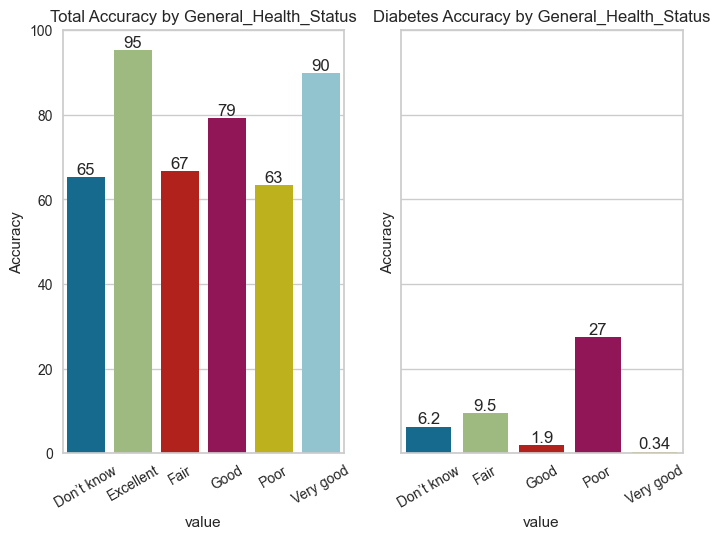

<Figure size 800x550 with 0 Axes>

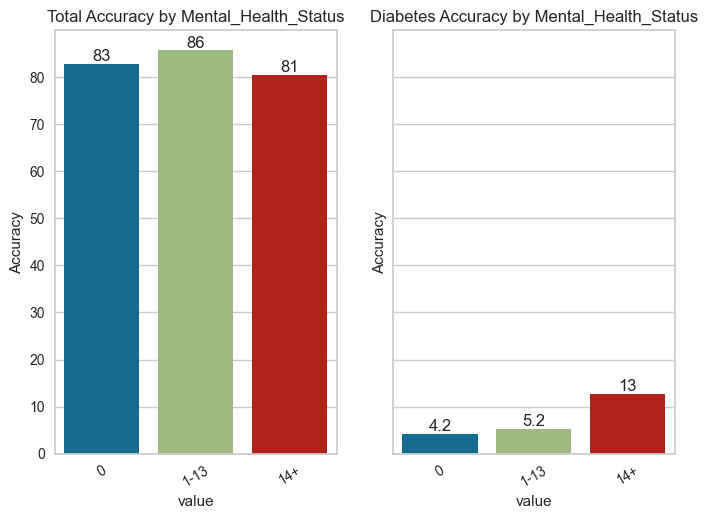

<Figure size 800x550 with 0 Axes>

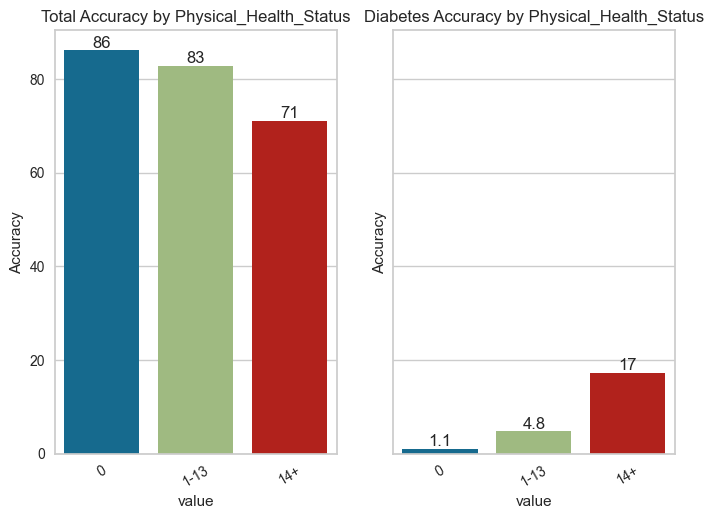

<Figure size 800x550 with 0 Axes>

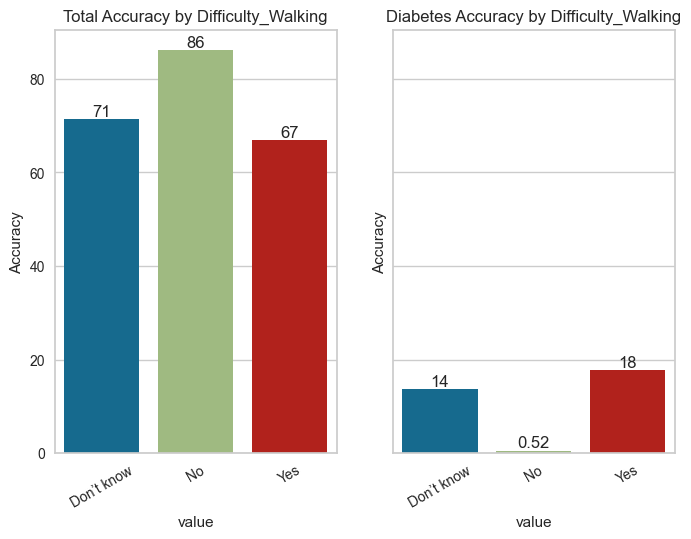

<Figure size 800x550 with 0 Axes>

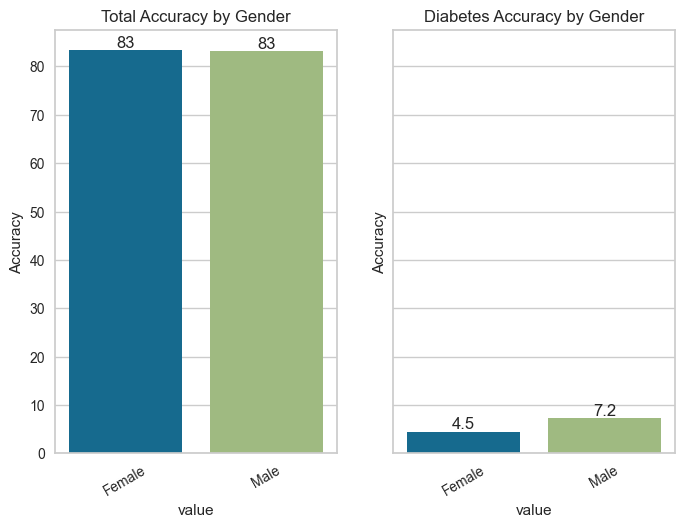

<Figure size 800x550 with 0 Axes>

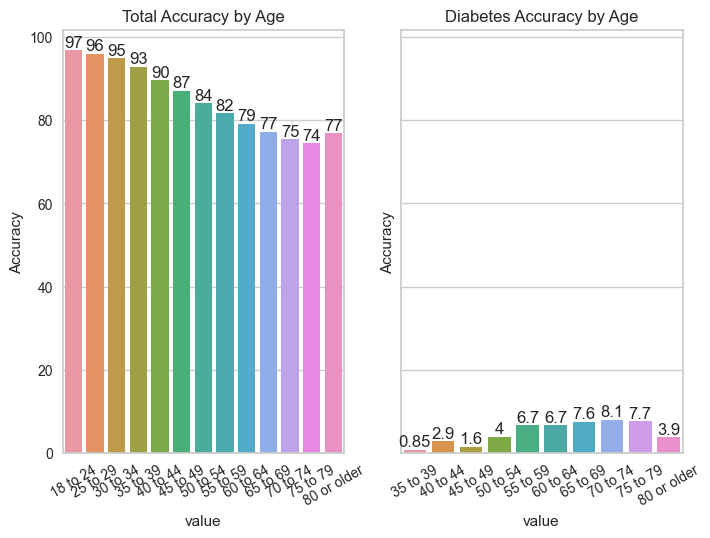

<Figure size 800x550 with 0 Axes>

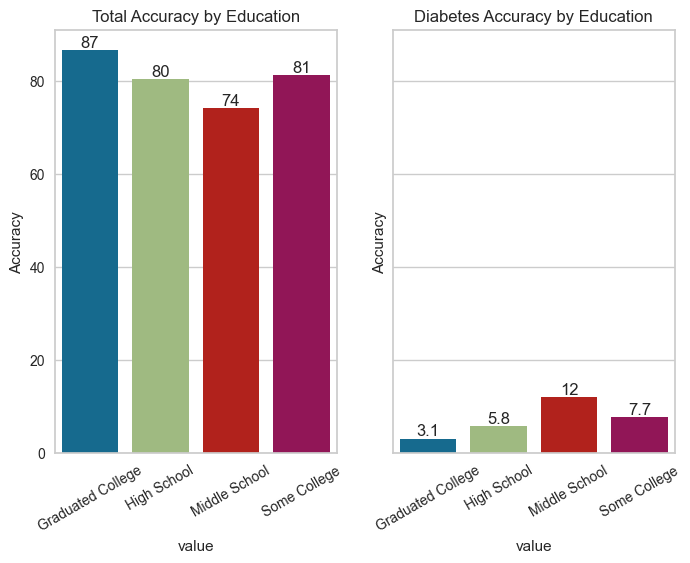

<Figure size 800x550 with 0 Axes>

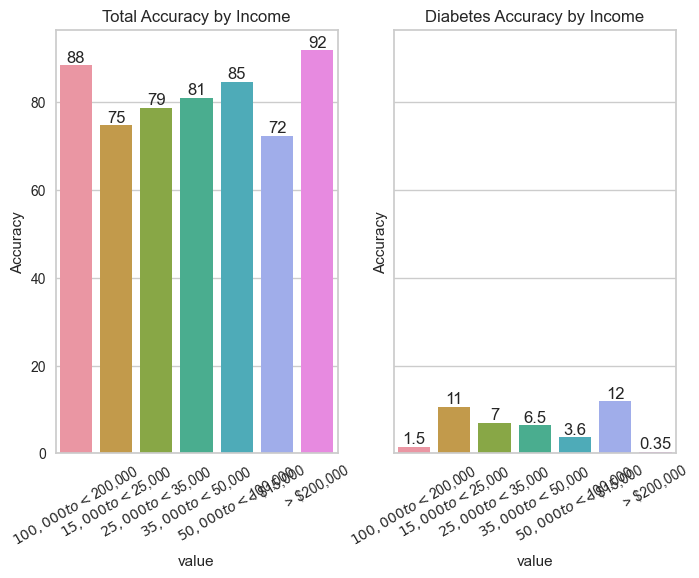

<Figure size 800x550 with 0 Axes>

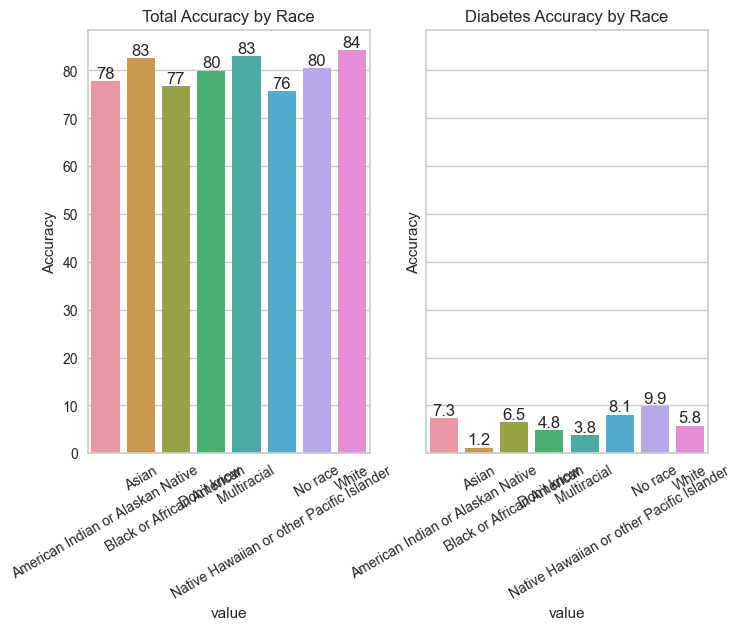

<Figure size 800x550 with 0 Axes>

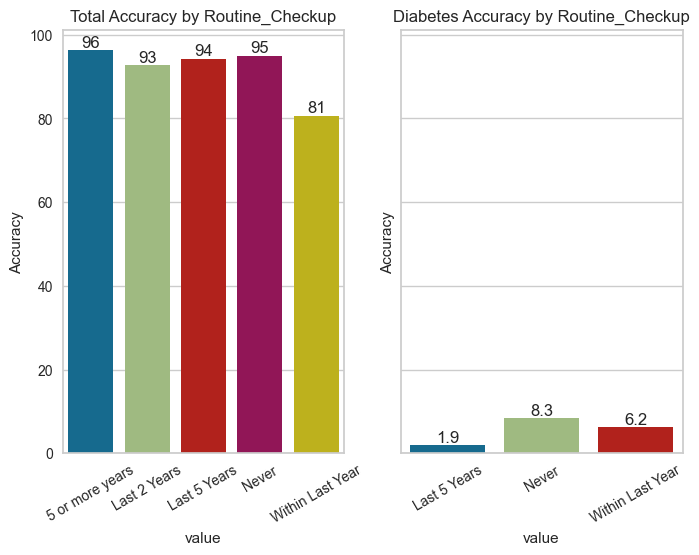

<Figure size 800x550 with 0 Axes>

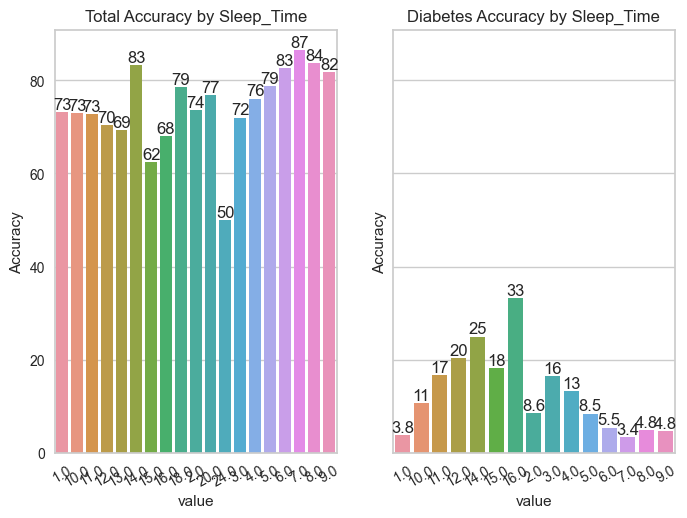

<Figure size 800x550 with 0 Axes>

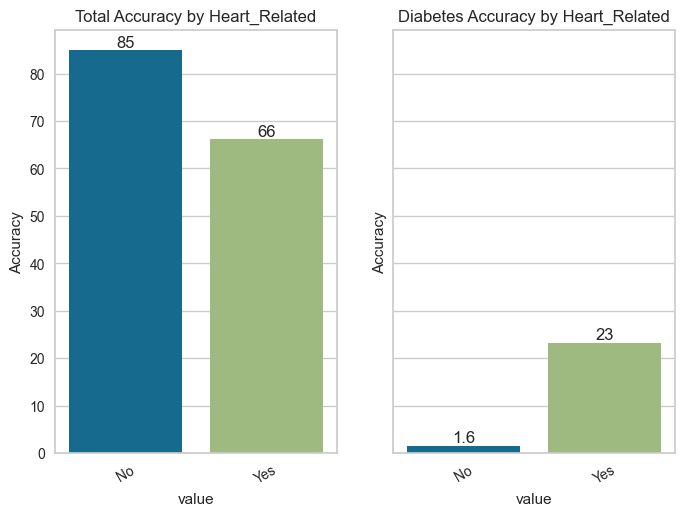

<Figure size 800x550 with 0 Axes>

In [73]:
plot_features = test_features.drop(['accurate','predict','diabetes'],axis=1)
for column_name in plot_features.columns:
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
    sns.barplot(x='value', y='Accuracy', data=diabetes_accuracy_df[diabetes_accuracy_df.feature==column_name], ax=ax2)
    ax2.set_title(f'Diabetes Accuracy by {column_name.title()}')
    ax2.tick_params(axis='x', rotation=30)
    for i in ax2.containers:
        ax2.bar_label(i,fmt='%.2g')
        
    sns.barplot(x='value', y='Accuracy', data=accuracy_df[accuracy_df.feature==column_name], ax=ax1)
    ax1.set_title(f'Total Accuracy by {column_name.title()}')
    ax1.tick_params(axis='x', rotation=30)
    for i in ax1.containers:
        ax1.bar_label(i,fmt='%.2g')
        
    plt.figure()

In [ ]:
plot_features = test_features.drop(['accurate','predict','diabetes'],axis=1)
for column_name in plot_features.columns:
    ax = sns.barplot(x='value', y='Accuracy', data=accuracy_df[accuracy_df.feature==column_name])
    ax.set_title(f'Total Accuracy by {column_name.title()}')
    ax.tick_params(axis='x', rotation=30)
    for i in ax.containers:
        ax.bar_label(i,)
    plt.figure()